In [312]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
%matplotlib inline

from sklearn import naive_bayes
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import cluster

from IPython.display import display
pd.options.display.max_columns = None

from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors

from sklearn import preprocessing
import time

In [474]:
listings = gpd.GeoDataFrame.from_file('Data/NYClisting.geojson')

In [234]:
listings.head(2)

,Median_income,Median_rent,accesstosubway,availability_365,beer_count,boro_ct_2010,calculated_host_listings_count,coffee_count,connectivityScore,geometry,host_id,host_name,id,index_left,last_review,latitude,longitude,minimum_nights,name,neighbourhood,neighbourhood_group,number_of_reviews,price,reviews_per_month,room_type
0,21855,1287,8.368050,242,0,2002400,10,0,0.0,POINT (-73.86406089014145 40.81274651012037),525710,Libby,14880182,1.0,2017-02-08,40.812747,-73.864061,2,Community Living in the Heart & Soul of NYC (3C),Clason Point,Bronx,9,59,1.53,Private room
1,21855,1287,8.380864,365,0,2000200,10,0,0.0,POINT (-73.86381389361847 40.81293405229447),525710,Libby,15359150,1.0,2017-02-10,40.812934,-73.863814,2,"Private Room for 2, Community House NYC (2A)",Clason Point,Bronx,2,43,0.42,Private room


In [164]:
listings.columns.tolist()

['Median_income',
 'Median_rent',
 'accesstosubway',
 'availability_365',
 'beer_count',
 'boro_ct_2010',
 'calculated_host_listings_count',
 'coffee_count',
 'connectivityScore',
 'geometry',
 'host_id',
 'host_name',
 'id',
 'index_left',
 'last_review',
 'latitude',
 'longitude',
 'minimum_nights',
 'name',
 'neighbourhood',
 'neighbourhood_group',
 'number_of_reviews',
 'price',
 'reviews_per_month',
 'room_type']

In [165]:
col = [u'Median_income',
     u'Median_rent',
     #u'accesstosubway',
     u'availability_365',
     u'beer_count',
     #u'boro_ct_2010',
     #u'calculated_host_listings_count',
     u'coffee_count',
     u'connectivityScore',
     #'geometry',
     #u'host_id',
     #u'host_name',
     #u'id',
     #u'index_left',
     #u'last_review',
     #u'latitude',
     #u'longitude',
     u'minimum_nights',
     #u'name',
     #u'neighbourhood',
     #u'neighbourhood_group',
     u'number_of_reviews',
     u'price',
     u'reviews_per_month',
     u'room_type']

In [166]:
listings[col].head(3)

,Median_income,Median_rent,availability_365,beer_count,coffee_count,connectivityScore,minimum_nights,number_of_reviews,price,reviews_per_month,room_type
0,21855,1287,242,0,0,0.0,2,9,59,1.53,Private room
1,21855,1287,365,0,0,0.0,2,2,43,0.42,Private room
2,21855,1287,336,0,0,0.0,1,6,76,1.37,Private room


In [167]:
listings[col].dtypes

Median_income         object
Median_rent           object
availability_365       int64
beer_count             int64
coffee_count           int64
connectivityScore    float64
minimum_nights         int64
number_of_reviews      int64
price                  int64
reviews_per_month    float64
room_type             object
dtype: object

In [475]:
listings.Median_income = pd.to_numeric(listings.Median_income, errors='coerce')
listings.Median_rent = pd.to_numeric(listings.Median_rent, errors='coerce')

### Outliers

In [476]:
listings = listings[listings.minimum_nights <= 7]

In [477]:
listings = listings[listings.price <= 500]

### Feature Distributions

In [478]:
len(listings)

37245

/Users/pichot/.pyenv/versions/3.5.2/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/Users/pichot/.pyenv/versions/3.5.2/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


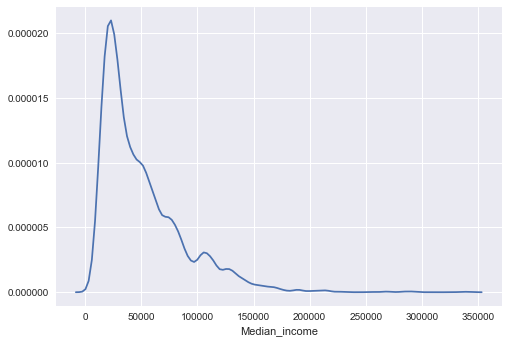

In [266]:
sns.distplot(listings.Median_income, hist=False)

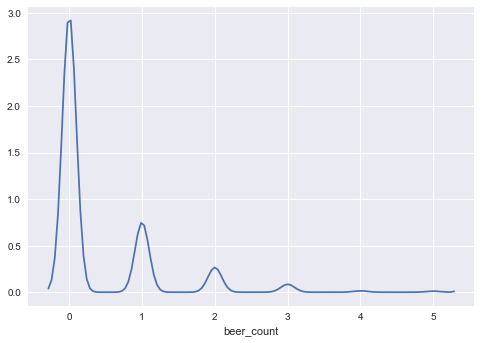

In [241]:
sns.distplot(listings.beer_count, hist=False)

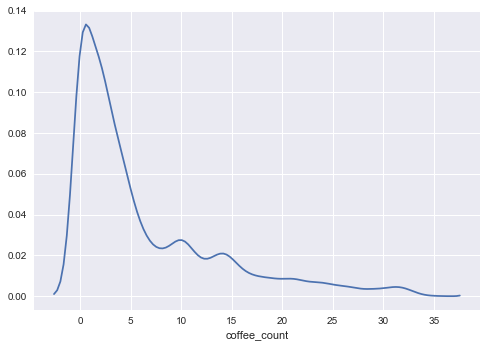

In [242]:
sns.distplot(listings.coffee_count, hist=False)

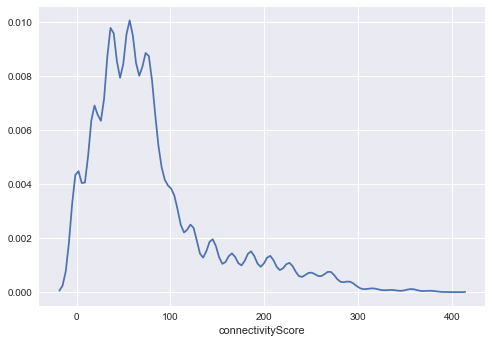

In [267]:
sns.distplot(listings.connectivityScore, hist=False)

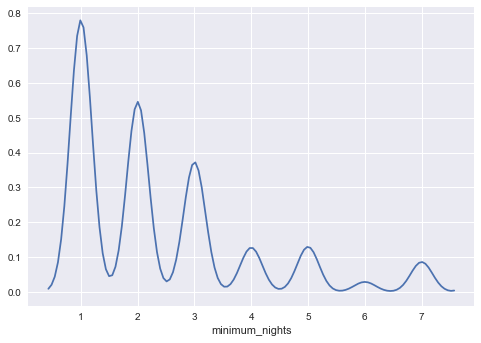

In [244]:
sns.distplot(listings.minimum_nights, hist=False)

/Users/pichot/.pyenv/versions/3.5.2/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/Users/pichot/.pyenv/versions/3.5.2/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


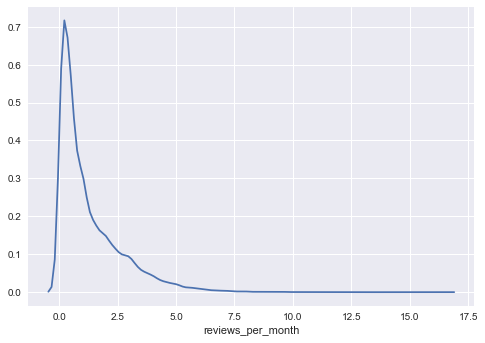

In [245]:
sns.distplot(listings.reviews_per_month, hist=False)

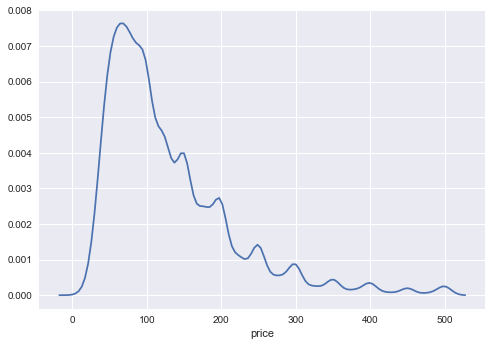

In [246]:
sns.distplot(listings.price, hist=False)

In [247]:
listings.room_type.unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

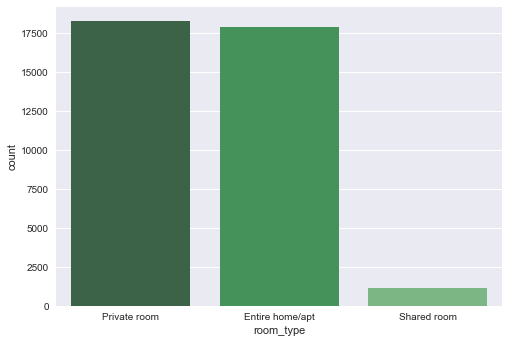

In [248]:
sns.countplot(x=listings.room_type, data=listings, palette="Greens_d");

In [479]:
listings['Private_room'] = 0
listings['Entire_home/apt'] = 0
listings['Shared_room'] = 0

In [480]:
def private(roomtype):
    if roomtype=='Private room':
        return 1
    else:
        return 0
def entire(roomtype):
    if roomtype=='Entire home/apt':
        return 1
    else:
        return 0
def shared(roomtype):
    if roomtype=='Shared room':
        return 1
    else:
        return 0

In [481]:
listings['Private_room'] = listings.room_type.map(private)
listings['Entire_home/apt'] = listings.room_type.map(entire)
listings['Shared_room'] = listings.room_type.map(shared)

### Feature selection 

In [482]:
features = list(listings.columns)

In [483]:
features =[u'Median_income',
     #u'Median_rent',
     #u'accesstosubway',
     #u'availability_365',
     u'beer_count',
     #u'boro_ct_2010',
     #u'calculated_host_listings_count',
     u'coffee_count',
     u'connectivityScore',
     #'geometry',
     #u'host_id',
     #u'host_name',
     #u'id',
     #u'index_left',
     #u'last_review',
     #u'latitude',
     #u'longitude',
     #u'minimum_nights',
     #u'name',
     #u'neighbourhood',
     #u'neighbourhood_group',
     #u'number_of_reviews',
     u'price',
     #u'reviews_per_month',
     #u'room_type',
     #'Private_room',
     #'Entire_home/apt',
     #'Shared_room'
          ]
features

['Median_income', 'beer_count', 'coffee_count', 'connectivityScore', 'price']

### Clean Nan Values

In [484]:
len(listings)

37245

In [485]:
listings[features].isnull().any(axis=1).sum()

921

In [486]:
reduced = listings[listings[features].isnull().any(axis=1)==False]

In [487]:
len(reduced)

36324

In [488]:
reduced[features].isnull().any(axis=1).sum()

0

In [489]:
reduced.head(2)

,Median_income,Median_rent,accesstosubway,availability_365,beer_count,boro_ct_2010,calculated_host_listings_count,coffee_count,connectivityScore,geometry,host_id,host_name,id,index_left,last_review,latitude,longitude,minimum_nights,name,neighbourhood,neighbourhood_group,number_of_reviews,price,reviews_per_month,room_type,Private_room,Entire_home/apt,Shared_room
0,21855.0,1287.0,8.368050,242,0,2002400,10,0,0.0,POINT (-73.86406089014145 40.81274651012037),525710,Libby,14880182,1.0,2017-02-08,40.812747,-73.864061,2,Community Living in the Heart & Soul of NYC (3C),Clason Point,Bronx,9,59,1.53,Private room,1,0,0
1,21855.0,1287.0,8.380864,365,0,2000200,10,0,0.0,POINT (-73.86381389361847 40.81293405229447),525710,Libby,15359150,1.0,2017-02-10,40.812934,-73.863814,2,"Private Room for 2, Community House NYC (2A)",Clason Point,Bronx,2,43,0.42,Private room,1,0,0


In [ ]:
with open('Data/jp-lustered.geojson', 'w') as f:
    f.write(sample.to_json())

### Sample Selection

In [27]:
# Per neighborhood
sample = reduced[reduced.neighbourhood == 'Crown Heights']

In [127]:
# Citywide
sample = reduced.sample(10000, random_state=123)

In [490]:
# Everything
sample = reduced

In [494]:
X = sample[features]

In [327]:
# Scale
X_scale = preprocessing.scale(X)
X = pd.DataFrame(X_scale, columns=X.columns)

In [495]:
len(X)

36324

In [496]:
X.head(2)

,Median_income,beer_count,coffee_count,connectivityScore,price
0,21855.0,0,0,0.0,59
1,21855.0,0,0,0.0,43


### Clustering

In [52]:
def kmeans_clusters(n):
    start_time = time.time()

    Xspec = KMeans(n_clusters = n)
    cl=Xspec.fit(X).labels_
    sample['kmeans'] = cl

    result2 = [str(x) for x in cl.tolist()]
    sample['kmeansCat'] = result2
    
    sns.countplot(x=sample['kmeansCat'], data=sample, palette="Greens_d");
    
    print("--- %s seconds ---" % (time.time() - start_time))

/Users/pichot/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/pichot/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--- 1.8131890296936035 seconds ---


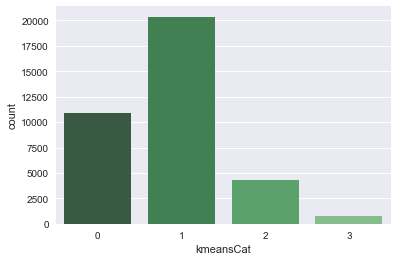

In [499]:
kmeans_clusters(4)

In [500]:
sample.groupby(sample.kmeansCat).kmeans.count()

kmeansCat
0    10906
1    20366
2     4312
3      740
Name: kmeans, dtype: int64

#### Agglomerative

In [211]:
def agg_clusters(n):
    start_time = time.time()

    Xspec = AgglomerativeClustering(n_clusters = n)
    cl=Xspec.fit(X).labels_
    sample['agglomerative'] = cl

    result2 = [str(x) for x in cl.tolist()]
    sample['agglomerativeCat'] = result2
    
    sns.countplot(x=sample['agglomerativeCat'], data=sample, palette="Greens_d");
    
    print("--- %s seconds ---" % (time.time() - start_time))

/Users/pichot/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/pichot/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--- 58.639832973480225 seconds ---


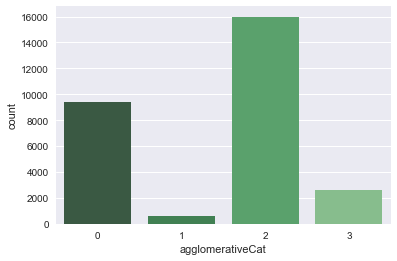

In [376]:
agg_clusters(4)

In [288]:
sample.groupby(sample.agglomerativeCat).agglomerativeCat.count()

agglomerativeCat
0     3206
1     9406
2    15989
Name: agglomerativeCat, dtype: int64

In [230]:
sample.dtypes

Median_income                     float64
Median_rent                       float64
accesstosubway                    float64
availability_365                    int64
beer_count                          int64
boro_ct_2010                       object
calculated_host_listings_count      int64
coffee_count                        int64
connectivityScore                 float64
geometry                           object
host_id                             int64
host_name                          object
id                                 object
index_left                        float64
last_review                        object
latitude                          float64
longitude                         float64
minimum_nights                      int64
name                               object
neighbourhood                      object
neighbourhood_group                object
number_of_reviews                   int64
price                               int64
reviews_per_month                 

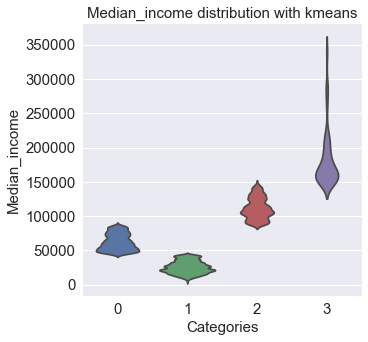

In [525]:
violin_feature('Median_income', 'kmeans')

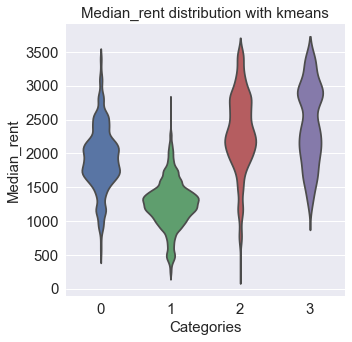

In [526]:
violin_feature('Median_rent', 'kmeans')

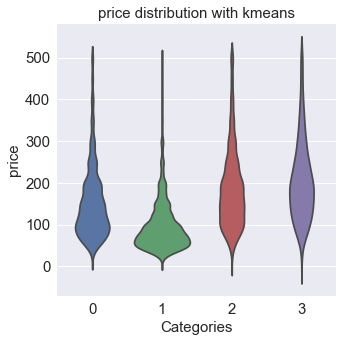

In [527]:
violin_feature('price', 'kmeans')

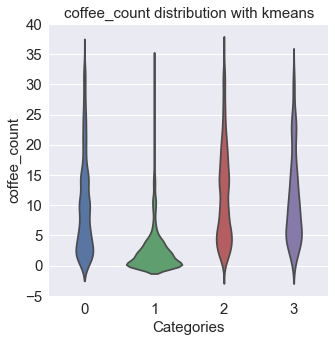

In [528]:
violin_feature('coffee_count', 'kmeans')

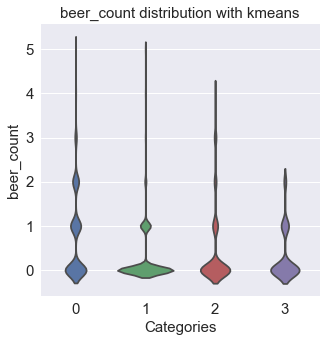

In [505]:
violin_feature('beer_count', 'kmeans')

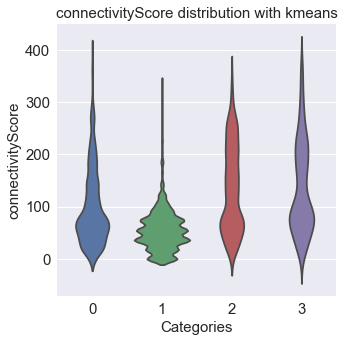

In [529]:
violin_feature('connectivityScore', 'kmeans')

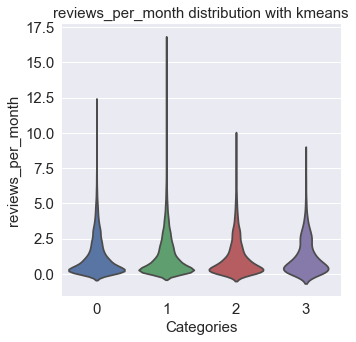

In [530]:
violin_feature('reviews_per_month', 'kmeans')

### Room Types

In [507]:
room_type = sample.groupby(sample.kmeans)['Private_room', 'Entire_home/apt', 'Shared_room'].sum()

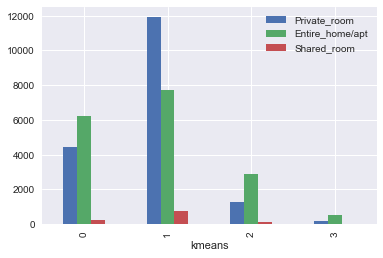

In [515]:
room_type.plot(kind='bar')

### Mapping

In [519]:
colors = {0:'blue', 1:'green', 2:'red', 3:'purple'}

In [306]:
set(sample['kmeans'])

{0, 1, 2, 3}

In [536]:
def individual_map(classifier, cid):
    f, ax = plt.subplots(figsize=(15,15))
    
    sample[sample[classifier] == cid].plot(color=colors[cid], legend=True, ax = ax, markersize=4)

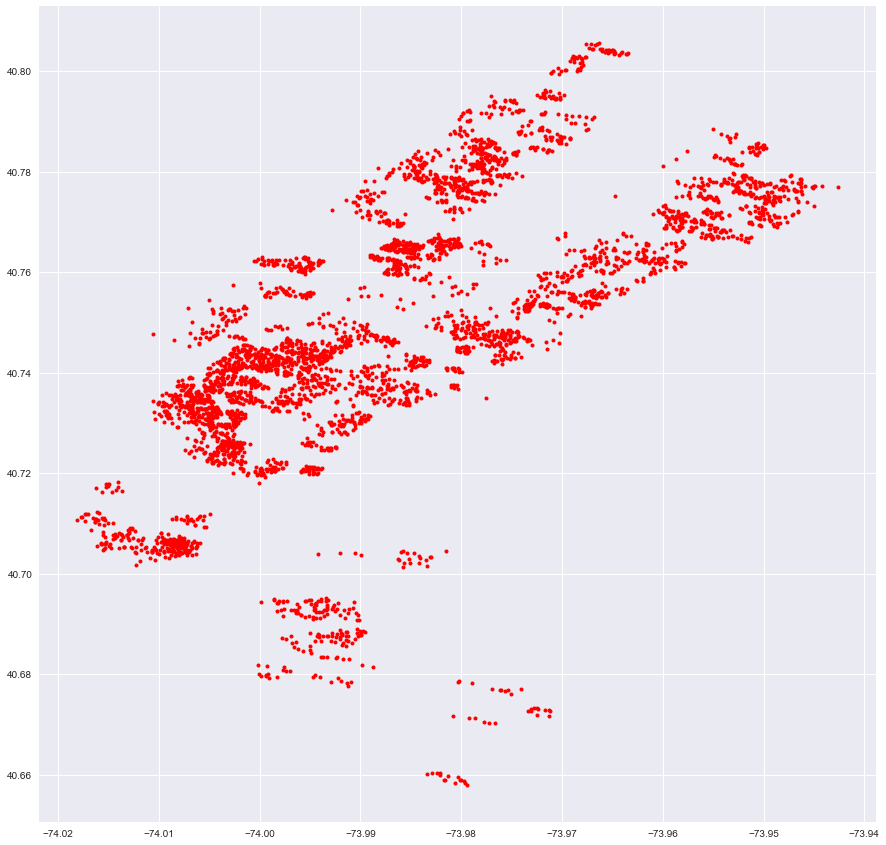

In [537]:
individual_map('kmeans', 2)

In [520]:
def cluster_map(classifier):
    f, ax = plt.subplots(figsize=(15,15))
    
    for cid in set(sample[classifier]):
        sample[sample[classifier] == cid].plot(color=colors[cid], legend=True, ax = ax, markersize=4)

    plt.xlabel('longitude')
    plt.ylabel('latitude')
    ticks = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    plt.title("NYC Airbnb clustered using {0}".format(classifier), size=20)

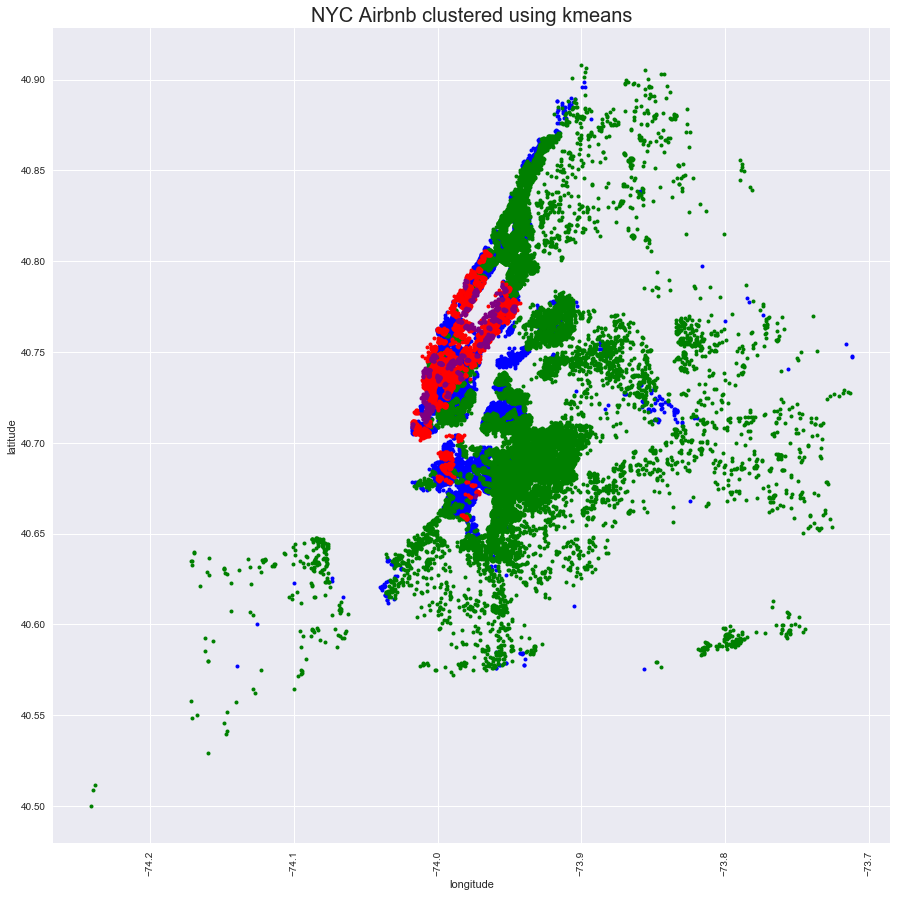

In [521]:
cluster_map('kmeans')

In [214]:
def feature_dist(feature, classifier):
    for cid in set(sample[classifier]):
        sns.distplot(sample[sample[classifier] == cid][feature], hist=False, label=str(cid))

    plt.legend()

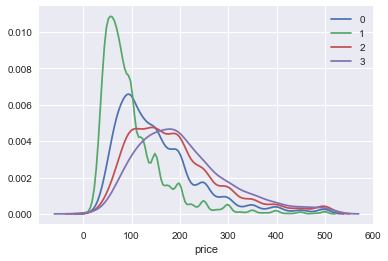

In [512]:
feature_dist('price', 'kmeans')

/Users/pichot/.pyenv/versions/3.5.2/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/Users/pichot/.pyenv/versions/3.5.2/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


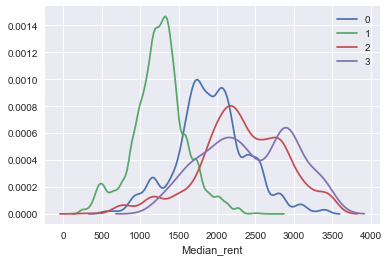

In [531]:
feature_dist('Median_rent', 'kmeans')

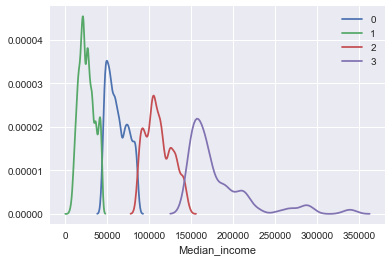

In [532]:
feature_dist('Median_income', 'kmeans')

In [523]:
def violin_feature(feature, classifier):
    f, ax = plt.subplots(figsize=(5,5))
    sns.violinplot(x=classifier, y=feature, data=sample, inner=None, ax=ax)
    ax.set_title('{0} distribution with {1}'.format(feature, classifier), fontsize=15)
    ax.set_xlabel('Categories', fontsize=15)
    plt.xticks( fontsize = 15)
    plt.yticks( fontsize = 15)
    ax.set_ylabel(feature, fontsize=15)